['booking id', 'booking_date_time', 'distance_travelled', 'time_taken', 'commission_base_cost', 'driver_base_cost', 'total_tax', 'total_trip_cost', 'ratings']
(4950, 9)


   booking id  booking_date_time  distance_travelled  time_taken  \
0  1890061540       43249.919444                  17        58.0   
1  1542148932       43153.925000                  18        43.0   
2  1672692603       43194.882639                   2         5.0   
3  1925600201       43258.932639                  15        49.0   
4  1530845664       43150.479861                  46         0.0   

   commission_base_cost  driver_base_cost  total_tax  total_trip_cost  ratings  
0                 57.73            230.91      21.94           311.00        3  
1                 52.04            208.16      19.76           279.96        5  
2                 19.70             78.81       7.49           106.00        5  
3                 51.24            239.96      21.22           312.00        5  
4              

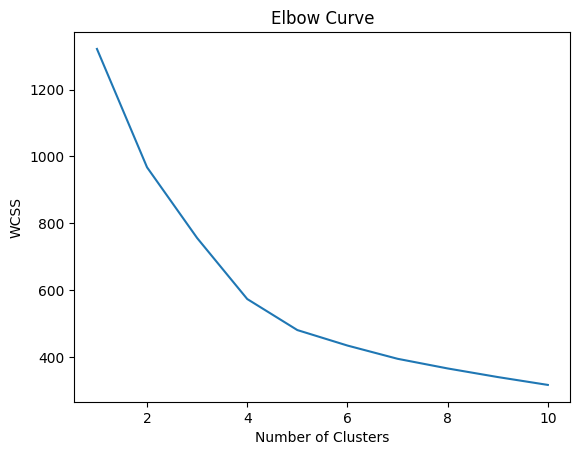

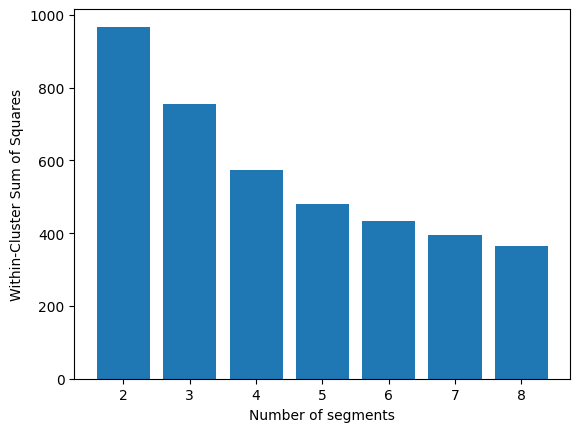

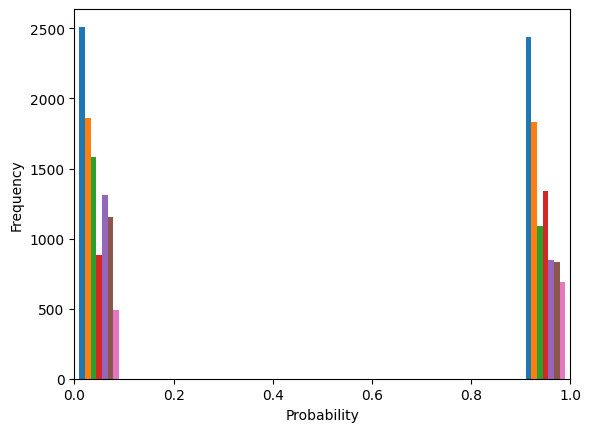

5    1120
7    1031
1     691
3     628
0     491
2     440
4     423
6     126
Name: cluster_kmeans, dtype: int64


4    1408
0    1230
2     807
1     781
5     543
6     150
3      16
7      15
Name: cluster_gmm, dtype: int64


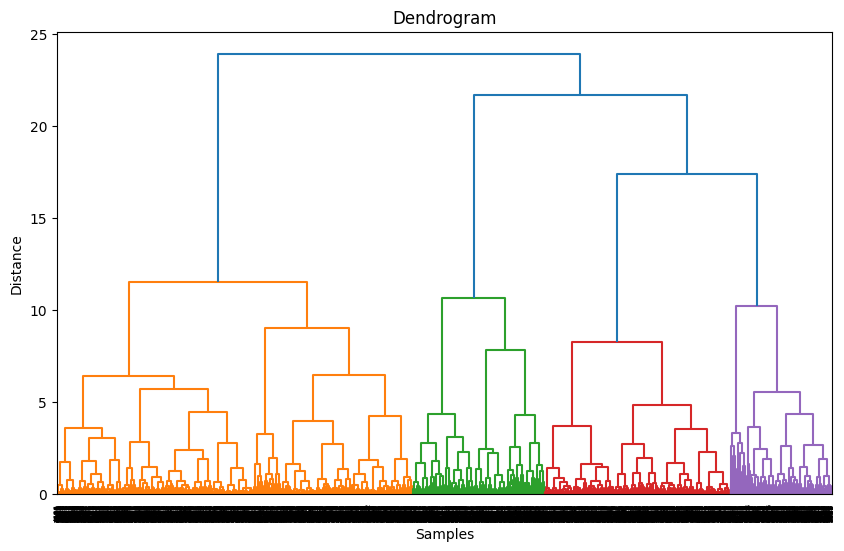

Cluster 3: 0.385
Cluster 5: 0.357
Cluster 2: 0.300
Cluster 1: 0.265
Cluster 7: 0.234
Cluster 0: 0.234
Cluster 4: 0.174
Cluster 6: 0.165
Model 2:
GaussianMixture(n_components=2, random_state=42)
Model 3:
GaussianMixture(n_components=3, random_state=42)
Model 4:
GaussianMixture(n_components=4, random_state=42)
Model 5:
GaussianMixture(n_components=5, random_state=42)
Model 6:
GaussianMixture(n_components=6, random_state=42)
Model 7:
GaussianMixture(n_components=7, random_state=42)
Model 8:
GaussianMixture(n_components=8, random_state=42)


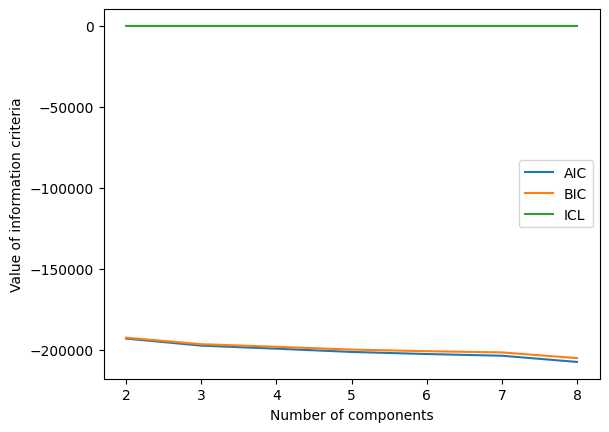

Mixture     0   1    2    3
K-means                    
0         846  72   33  634
1         618  52   36  381
2        1170  47   42  399
3           0  13  431  176
Mixture   0     1    2    3
K-means                    
0        15   878   89  603
1         5   650   83  349
2         9  1196   80  373
3        94     0  339  187
Log-Likelihood (Mixture Model with Fixed Clusters): 20.300543660165935
Log-Likelihood (Fitted Mixture Model): 20.157875600591762


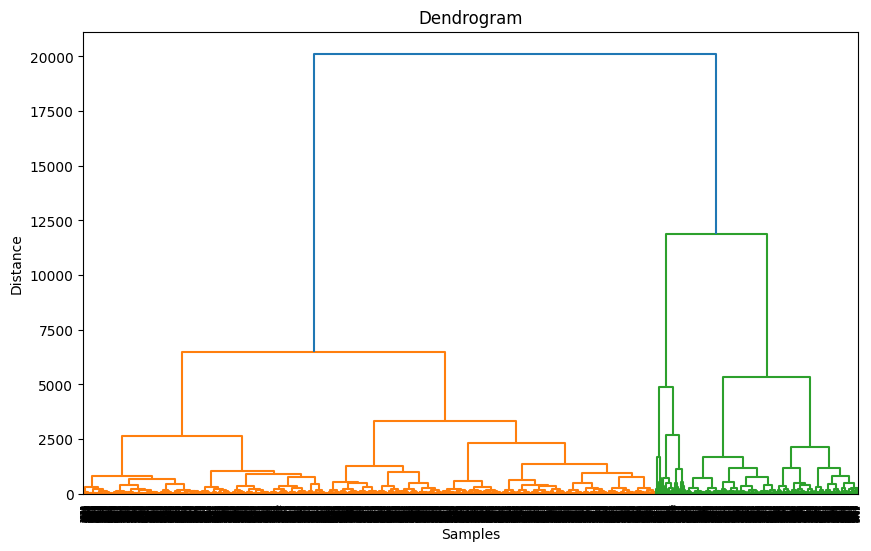

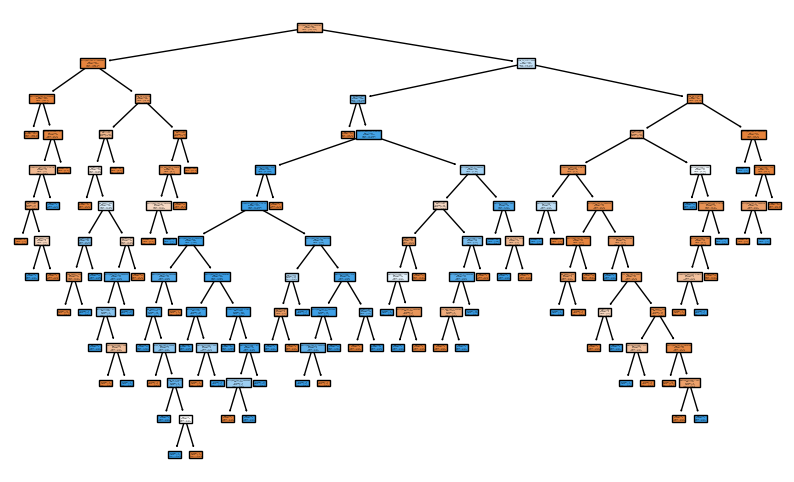

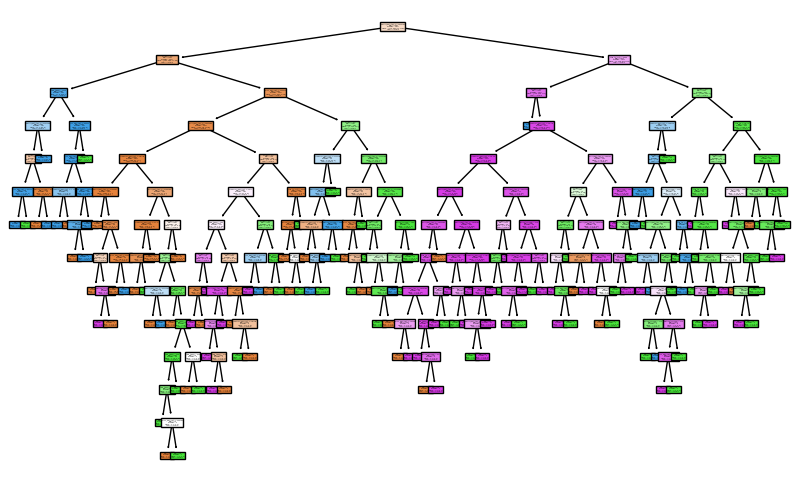

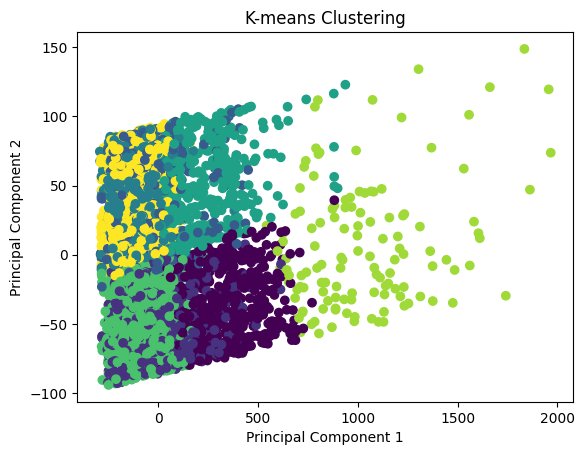

Accuracy: 0.968


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Read the dataset
df = pd.read_csv('OLA_trips_dataset.csv')
col = df.columns.tolist()
print(col)

dim = df.shape
print(dim)
print("\n")

head_data = df.head()
print(head_data)

# Select relevant columns for segmentation
features = df.iloc[:, 1:9]  # Columns 2 to 8 (adjust the indices as needed)

# Apply PCA for dimensionality reduction
pca = PCA()
features_pca = pca.fit_transform(features)

# Preprocess the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve to identify the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Perform K-means clustering
k_values = range(2, 9)
results = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(features_scaled)
    results.append(kmeans)

# Plot number of segments vs. within-cluster sum of squares
plt.bar(k_values, [res.inertia_ for res in results])
plt.xlabel("Number of segments")
plt.ylabel("Within-Cluster Sum of Squares")
plt.show()

# Plot histogram of cluster membership probabilities
plt.hist([res.labels_ for res in results], bins=10, range=(0, 1))
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

# Add cluster labels to the dataset
df['cluster_kmeans'] = results[-1].labels_

# View the cluster assignments
print(df['cluster_kmeans'].value_counts())
print("\n")

# Apply Gaussian Mixture Models
gmm = GaussianMixture(n_components=results[-1].n_clusters, random_state=42)
gmm.fit(features_scaled)
df['cluster_gmm'] = gmm.predict(features_scaled)

# View the cluster assignments
print(df['cluster_gmm'].value_counts())

# Plot dendrogram
linkage_matrix = linkage(features_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Calculate silhouette samples
silhouette_vals = silhouette_samples(features_scaled, df['cluster_kmeans'])
# Calculate the silhouette scores
silhouette_scores = silhouette_vals

# Create a DataFrame to store the silhouette scores and cluster labels
silhouette_df = pd.DataFrame({'Cluster': df['cluster_kmeans'], 'Silhouette Score': silhouette_scores})

# Calculate the average silhouette score for each cluster
avg_silhouette_scores = silhouette_df.groupby('Cluster')['Silhouette Score'].mean()

# Sort the silhouette scores in descending order
sorted_avg_silhouette_scores = avg_silhouette_scores.sort_values(ascending=False)

# Print the average silhouette scores for each cluster
for cluster, score in sorted_avg_silhouette_scores.items():
    print(f"Cluster {cluster}: {score:.3f}")

# Fit Gaussian mixture models with different numbers of components
models = []
for k in range(2, 9):
    model = GaussianMixture(n_components=k, random_state=42)
    model.fit(features_scaled)
    models.append(model)

# Print the fitted mixture models
for i, model in enumerate(models):
    print(f"Model {i+2}:")
    print(model)

# Plot information criteria
AIC = [model.aic(features_scaled) for model in models]
BIC = [model.bic(features_scaled) for model in models]
ICL = [model.lower_bound_ for model in models]
plt.plot(k_values, AIC, label="AIC")
plt.plot(k_values, BIC, label="BIC")
plt.plot(k_values, ICL, label="ICL")
plt.ylabel("Value of information criteria")
plt.xlabel("Number of components")
plt.legend()
plt.show()

# Extract the model with the desired number of components
desired_k = 4
desired_model = models[desired_k - 2]

# Obtain the cluster assignments from the desired model
MD_m4_clusters = desired_model.predict(features_scaled)

# Compare cluster assignments from K-means and Gaussian mixture model
kmeans = KMeans(n_clusters=desired_k, random_state=1234)
kmeans_clusters = kmeans.fit_predict(features_scaled)
table = pd.crosstab(kmeans_clusters, MD_m4_clusters, rownames=["K-means"], colnames=["Mixture"])
print(table)

# Fit a Gaussian mixture model with fixed cluster assignments
features_m4a = GaussianMixture(n_components=desired_k)
features_m4a.fit(features_scaled, MD_m4_clusters)

# Compare cluster assignments from K-means and the fitted Gaussian mixture model
MD_m4a_clusters = features_m4a.predict(features_scaled)
table = pd.crosstab(kmeans_clusters, MD_m4a_clusters, rownames=["K-means"], colnames=["Mixture"])
print(table)

# Calculate log-likelihoods of the fitted Gaussian mixture models
loglik_m4a = features_m4a.score(features_scaled)
loglik_m4 = desired_model.score(features_scaled)
print(f"Log-Likelihood (Mixture Model with Fixed Clusters): {loglik_m4a}")
print(f"Log-Likelihood (Fitted Mixture Model): {loglik_m4}")

features_dmatrix = pdist(features, metric='euclidean')  # Calculate distance matrix using Euclidean distance
features_vclust = linkage(features_dmatrix, method='ward')
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(features_vclust)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


# Perform hierarchical clustering using Ward's method
features=features_scaled.transpose()
features_dmatrix = pdist(features_scaled, metric='euclidean')  # Calculate distance matrix using Euclidean distance
features_vclust = linkage(features_dmatrix, method='ward')
cluster_model = AgglomerativeClustering(n_clusters=4, linkage='ward')
features_k4 = cluster_model.fit_predict(features.transpose())
hierarchical_clusters = cluster_model.fit_predict(features_scaled)

# Build the decision tree classifier for K-means clustering
tree = DecisionTreeClassifier()
X = df.iloc[:, 1:9]  # Select columns 1 to 8 (adjust the indices as needed)
y = (features_k4 == 3).astype(int)
tree.fit(X, y)

# Plot the decision tree for K-means clustering
plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=df.columns[1:9], class_names=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], filled=True)
plt.show()

# Build the decision tree classifier
tree1 = DecisionTreeClassifier()
X = df.iloc[:, 1:9]  # Select columns 1 to 8 (adjust the indices as needed)
y1 = hierarchical_clusters
tree1.fit(X, y1)

# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(tree1, feature_names=df.columns[1:9], class_names=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], filled=True)
plt.show()

# Visualize the clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['cluster_kmeans'])
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, hierarchical_clusters, test_size=0.2, random_state=42)

# Train a decision tree classifier for hierarchical clustering
tree_hierarchical = DecisionTreeClassifier(random_state=42)
tree_hierarchical.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_hierarchical.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")


# Alternatively, you can save the cluster assignments and silhouette values to a new CSV file
df.to_csv('segmented_dataset.csv', index=False)


Methods Used : Binary Logistic Regression, Multinomial Logistic Regression, Tree Based Method-(Decision Method)


8    1303
0     927
2     813
7     463
5     376
9     313
1     266
3     235
4     202
6      52
Name: cluster_gmm, dtype: int64


Log-Likelihood: 23.576419559532688




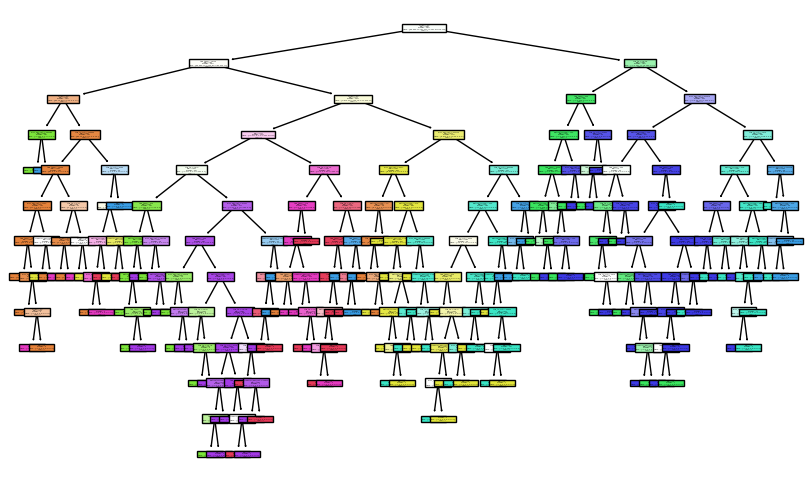

Binary Logistic Regression Coefficients:
distance_travelled: 1.767
time_taken: -8.606
commission_base_cost: -0.051
driver_base_cost: 3.368
total_tax: 1.805
total_trip_cost: 2.577
ratings: -14.856

Multinomial Logistic Regression Coefficients:
distance_travelled: -1.160, 4.647, 0.357, -2.477, -1.162, -1.817, 19.198
time_taken: -0.248, -0.599, -0.390, -0.439, -0.443, -0.438, -21.219
commission_base_cost: -5.237, -1.520, -2.855, -3.689, -3.459, -3.579, -10.262
driver_base_cost: 2.215, 3.999, 0.482, 3.383, 2.048, 2.846, 13.811
total_tax: 4.113, 4.007, 0.020, 3.194, 1.703, 2.526, -8.971
total_trip_cost: -4.213, -10.831, -2.568, -2.937, -2.906, -2.918, 15.954
ratings: 0.674, -2.876, 3.013, 3.187, 3.407, 3.024, -2.067

Binary Logistic Regression Log-Likelihood: 0.955959595959596
Multinomial Logistic Regression Log-Likelihood: 0.8909090909090909


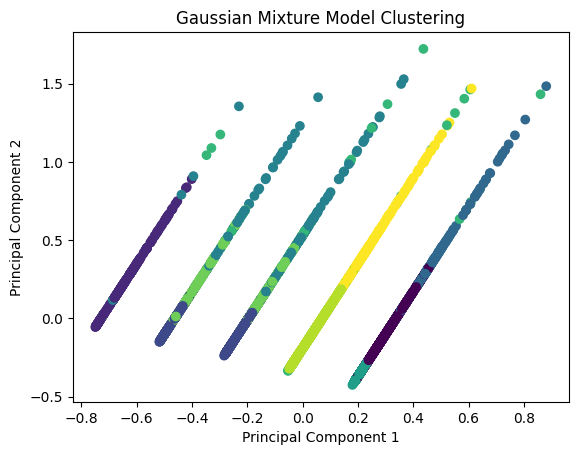

In [13]:
print("Methods Used : Binary Logistic Regression, Multinomial Logistic Regression, Tree Based Method-(Decision Method)")
print("\n")


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# Read the dataset
df = pd.read_csv('OLA_trips_dataset.csv')

# Select relevant columns for segmentation
features = df[['distance_travelled', 'time_taken', 'commission_base_cost', 'driver_base_cost', 'total_tax', 'total_trip_cost', 'ratings']]

# Preprocess the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Find the optimal number of clusters based on the elbow curve
optimal_clusters = np.argmin(wcss) + 1

# Perform Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(features_scaled)

# Add cluster labels to the dataset
df['cluster_gmm'] = gmm.predict(features_scaled)

# View the cluster assignments
print(df['cluster_gmm'].value_counts())
print("\n")

# Calculate log-likelihood of the fitted Gaussian Mixture Model
loglik = gmm.score(features_scaled)
print(f"Log-Likelihood: {loglik}")
print("\n")

# Perform hierarchical clustering using Ward's method
cluster_model = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
hierarchical_clusters = cluster_model.fit_predict(features_scaled)

# Build the decision tree classifier
tree = DecisionTreeClassifier()
X = features
y = hierarchical_clusters
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(10, 6))
plot_tree(tree, feature_names=X.columns, class_names=[str(i) for i in range(optimal_clusters)], filled=True)
plt.show()

# Perform binary logistic regression
binary_logreg = LogisticRegression(random_state=42)
binary_logreg.fit(features_scaled, (df['cluster_gmm'] > 0).astype(int))

# Perform multinomial logistic regression
multinomial_logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
multinomial_logreg.fit(features_scaled, df['cluster_gmm'])

# Print the coefficients of the binary logistic regression model
print("Binary Logistic Regression Coefficients:")
for feature, coef in zip(features.columns, binary_logreg.coef_[0]):
    print(f"{feature}: {coef:.3f}")

# Print the coefficients of the multinomial logistic regression model
print("\nMultinomial Logistic Regression Coefficients:")
for feature, coef in zip(features.columns, multinomial_logreg.coef_):
    print(f"{feature}: {', '.join([f'{c:.3f}' for c in coef])}")

# Calculate log-likelihood scores for binary and multinomial logistic regression models
binary_loglik = binary_logreg.score(features_scaled, (df['cluster_gmm'] > 0).astype(int))
multinomial_loglik = multinomial_logreg.score(features_scaled, df['cluster_gmm'])
print(f"\nBinary Logistic Regression Log-Likelihood: {binary_loglik}")
print(f"Multinomial Logistic Regression Log-Likelihood: {multinomial_loglik}")

# Visualize the clusters
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=df['cluster_gmm'])
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Save the cluster assignments and silhouette values to a new CSV file
df.to_csv('segmented_dataset.csv', index=False)
